## Automated Image Caption Generator with CNN and LSTM Architectures

In [ ]:

# 📦 Step 1: Install and Import Libraries
!pip install -q keras_preprocessing
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import matplotlib.pyplot as plt
import pickle
import os
from PIL import Image
import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [ ]:
dataset_text = '/kaggle/input/flickr8k/captions.txt'
dataset_images = '/kaggle/input/flickr8k/Images'

def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

def load_descriptions(doc):
    descriptions = {}
    skipped = 0
    # Split by newlines and skip the header
    lines = doc.strip().split('\n')[1:]

    for line in lines:
        tokens = line.split(',')

        # Skip lines that don't have exactly two tokens (image and caption)
        if len(tokens) != 2:
            skipped += 1
            continue

        image_id, image_desc = tokens
        image_id = image_id.split('.')[0]  # Get the image ID without the file extension

        if image_id not in descriptions:
            descriptions[image_id] = []

        descriptions[image_id].append('startseq ' + image_desc.strip() + ' endseq')

    print(f"✅ Loaded {len(descriptions)} image descriptions.")
    print(f"⚠️ Skipped {skipped} lines due to format issues.")
    return descriptions

# Load and parse the captions
doc = load_doc(dataset_text)
descriptions = load_descriptions(doc)

# Optional: view a sample description
sample_key = list(descriptions.keys())[0]
print(f"\n📸 Sample image ID: {sample_key}")
print("📝 Captions:")
print("\n".join(descriptions[sample_key]))


✅ Loaded 8091 image descriptions.
⚠️ Skipped 2447 lines due to format issues.

📸 Sample image ID: 1000268201_693b08cb0e
📝 Captions:
startseq A child in a pink dress is climbing up a set of stairs in an entry way . endseq
startseq A girl going into a wooden building . endseq
startseq A little girl climbing into a wooden playhouse . endseq
startseq A little girl climbing the stairs to her playhouse . endseq
startseq A little girl in a pink dress going into a wooden cabin . endseq


In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
import numpy as np
from tqdm import tqdm
import os

model = InceptionV3(weights='imagenet')
model = Model(model.input, model.layers[-2].output)

def preprocess(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return preprocess_input(x)

def extract_features(directory):
    features = {}
    for name in tqdm(os.listdir(directory)):
        filename = os.path.join(directory, name)
        image_id = name.split('.')[0]
        img = preprocess(filename)
        feature = model.predict(img, verbose=0)
        features[image_id] = feature
    return features

features = extract_features(dataset_images)


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


100%|██████████| 8091/8091 [13:54<00:00,  9.70it/s]


In [ ]:
# ✏️ Prepare tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

all_captions = []
for key in descriptions:
    all_captions.extend(descriptions[key])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

# 🧮 Get max sequence length
max_length = max(len(caption.split()) for caption in all_captions)
print(f"Max caption length: {max_length}")

Vocabulary Size: 8221
Max caption length: 36


In [ ]:
# 🔁 Create data generator
from keras.utils import to_categorical

def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = [], [], []
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size, batch_size):
    while True:
        keys = list(descriptions.keys())
        for i in range(0, len(keys), batch_size):
            X1, X2, y = [], [], []
            for key in keys[i:i+batch_size]:
                if key not in photos:
                    continue
                photo = photos[key][0]
                desc_list = descriptions[key]
                in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
                for j in range(len(in_img)):
                    X1.append(in_img[j])
                    X2.append(in_seq[j])
                    y.append(out_word[j])
            # yield a tuple of (input_data, target_data) instead of a list
            yield (np.array(X1), np.array(X2)), np.array(y) # Changed this line to yield a tuple instead of a list

In [ ]:
# 🧠 Define the model
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, use_cudnn=False)(se2) # Disable cuDNN for LSTM

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = define_model(vocab_size, max_length)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 36, 256)   │  2,104,576 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 36, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 36)        │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    524,544 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8221)      │  2,112,797 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,333,021 (20.34 MB)

 Trainable params: 5,333,021 (20.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 🚀 Train the model
epochs = 50
batch_size = 64
steps = len(descriptions) // batch_size

generator = data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 509s 4s/step - loss: 5.8776
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 81s 613ms/step - loss: 3.9207
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 628ms/step - loss: 3.3973
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 628ms/step - loss: 3.1404
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 627ms/step - loss: 2.9793
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 624ms/step - loss: 2.8544
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 627ms/step - loss: 2.7584
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 625ms/step - loss: 2.6753
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 627ms/step - loss: 2.6147
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 626ms/step - loss: 2.5516
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 627ms/step - loss: 2.4968
Epoch 12/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 627ms/step - loss: 2.4491
Epoch 13/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 627ms/step - loss: 2.4035
Epoch 14/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 626ms/step - loss: 2.3524
Epoch 15/50
126/1

In [ ]:
# 💾 Save the model
model.save('image_caption_model.h5')

# 🧪 Evaluate with BLEU Score
from nltk.translate.bleu_score import corpus_bleu

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text

actual, predicted = [], []
for key in list(descriptions.keys())[:100]:
    yhat = generate_desc(model, tokenizer, features[key], max_length)
    references = [d.split() for d in descriptions[key]]
    actual.append(references)
    predicted.append(yhat.split())

print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.541958
BLEU-2: 0.357114
BLEU-3: 0.264587
BLEU-4: 0.143712


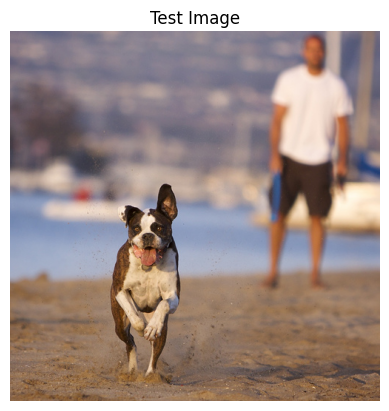


✅ Actual Captions:
• A black and white dog running on the beach while a man stands behind it .
• A dog running on the beach while a man watches .
• A dog running toward the camera with a man in the background
• A dog running at the beach with a man looking in the background .
• The dog is happily running on the beach .

🤖 Predicted Caption:
• a black and white dog running on the beach


In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# 🔁 Reuse your generate_desc function
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text.replace('startseq', '').replace('endseq', '').strip()

# 📸 Function to display random image and captions
def test_random_image(model, descriptions, features, tokenizer, max_length, image_folder):
    # Pick random image ID
    image_id = random.choice(list(descriptions.keys()))
    filename = image_id + ".jpg"

    # Show the image
    image_path = os.path.join(image_folder, filename)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Test Image")
    plt.show()

    # Print actual captions
    print("\n✅ Actual Captions:")
    for caption in descriptions[image_id]:
        print("•", caption.replace("startseq", "").replace("endseq", "").strip())

    # Generate prediction
    y_pred = generate_desc(model, tokenizer, features[image_id], max_length)
    print("\n🤖 Predicted Caption:\n•", y_pred)

# 🔍 Run it on random image
test_random_image(model, descriptions, features, tokenizer, max_length, dataset_images)
